In [21]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from numpy import genfromtxt
from sklearn import kernel_ridge
import os
print(len(os.sched_getaffinity(0)))
from numba import jit, njit, prange

2


In [15]:
path_to_train = '/content/wine_training.csv'
path_to_test = '/content/wine_test.csv'

train = genfromtxt(path_to_train, delimiter=',')
test = genfromtxt(path_to_test, delimiter=',')

print('TRAIN SET')
print(train)
print('ALL BUT LAST')
print(train[:, :-1])
print('LAST')
print(train[:, -1])

TRAIN SET
[[ 6.1   0.6   0.08 ...  0.54 11.    5.  ]
 [10.3   0.53  0.48 ...  0.59  9.3   6.  ]
 [ 6.9   0.49  0.19 ...  0.64  9.8   6.  ]
 ...
 [ 7.    0.38  0.49 ...  0.77 11.4   6.  ]
 [10.    0.35  0.47 ...  0.52 12.    6.  ]
 [ 7.    0.6   0.3  ...  1.17 10.2   5.  ]]
ALL BUT LAST
[[ 6.1   0.6   0.08 ...  3.38  0.54 11.  ]
 [10.3   0.53  0.48 ...  3.12  0.59  9.3 ]
 [ 6.9   0.49  0.19 ...  3.38  0.64  9.8 ]
 ...
 [ 7.    0.38  0.49 ...  3.39  0.77 11.4 ]
 [10.    0.35  0.47 ...  3.23  0.52 12.  ]
 [ 7.    0.6   0.3  ...  3.3   1.17 10.2 ]]
LAST
[5. 6. 6. ... 6. 6. 5.]


In [16]:
norm_train = (train - train.mean(axis=0)) / train.std(axis=0)
norm_test = (test - test.mean(axis=0)) / test.std(axis=0)

In [17]:
#Use linear regression to fit a linear model to the training set 
LinearRegressor = sklearn.linear_model.LinearRegression()
LinearRegressor.fit(norm_train[:, :-1], norm_train[:, -1])
predicted_train = LinearRegressor.predict(norm_train[:, :-1])
print(f'LINEAR REGRESSION TRAINING MSE: {sklearn.metrics.mean_squared_error(predicted_train, norm_train[:, -1])}')
predicted_test = LinearRegressor.predict(norm_test[:, :-1])
print(f'LINEAR REGRESSION TEST MSE: {sklearn.metrics.mean_squared_error(predicted_test, norm_test[:, -1])}')

LINEAR REGRESSION TRAINING MSE: 0.6278484956554817
LINEAR REGRESSION TEST MSE: 0.7021527395264012


In [43]:
#Use kernel ridge regression to fit a non-linear model to the training set

#Gaussian (RBF) Kernel 
@jit(nogil=True)
def GaussianError(args):
  RBFRegresor = kernel_ridge.KernelRidge(alpha = args[0], kernel = 'rbf', gamma = args[1])
  RBFRegresor.fit(norm_train[:, :-1], norm_train[:, -1])
  predicted_train = RBFRegresor.predict(norm_train[:, :-1])
  #print(f'GAUSSIAN KERNEL TRAINING MSE: {sklearn.metrics.mean_squared_error(predicted_train, norm_train[:, -1])}')
  predicted_test = RBFRegresor.predict(norm_test[:, :-1])
  #print(f'GAUSSIAN KERNEL TEST MSE: {sklearn.metrics.mean_squared_error(predicted_test, norm_test[:, -1])}')
  train_mse = sklearn.metrics.mean_squared_error(predicted_train, norm_train[:, -1])
  return train_mse

#Laplacian kernel
@njit(nogil=True)
def LaplacianError(alpha, gamma, best_train):
  LaplacianRegresor = kernel_ridge.KernelRidge(alpha = 1.0, kernel = 'laplacian', gamma = 1.0)
  LaplacianRegresor.fit(norm_train[:, :-1], norm_train[:, -1])
  predicted_train = LaplacianRegresor.predict(norm_train[:, :-1])
  print(f'LAPLACIAN KERNEL TRAINING MSE: {sklearn.metrics.mean_squared_error(predicted_train, norm_train[:, -1])}')
  predicted_test = LaplacianRegresor.predict(norm_test[:, :-1])
  print(f'LAPLACIAN KERNEL TEST MSE: {sklearn.metrics.mean_squared_error(predicted_test, norm_test[:, -1])}')
  train_mse = sklearn.metrics.mean_squared_error(predicted_train, norm_train[:, -1])
  if train_mse > best_train:
    best_alpha = alpha
    best_gamma = gamma

In [57]:
print(GaussianError(1.0))

0.20315143936568633


ValueError: ignored

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:197: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  "Singular matrix in solving dual problem. Using "


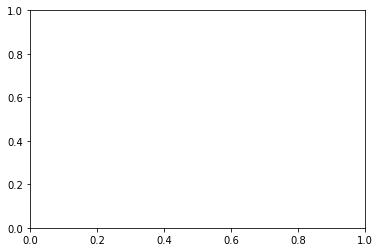

In [68]:
from concurrent.futures import ThreadPoolExecutor
import seaborn as sns
best_alpha = 0
executor = ThreadPoolExecutor(len(os.sched_getaffinity(0)))
alpha_range = np.arange(0, 10, 1)
gamma_range = np.arange(0, 10, 1)
X, Y = np.meshgrid(alpha_range, gamma_range)
args = zip(alpha_range, gamma_range)
results = executor.map(GaussianError, args)
fig, ax = plt.subplots()
ax.pcolormesh(X, Y, results)

In [26]:
best_alpha = 0 
best_gamma = 0
@jit(nogil=True, parallel=True)
def run_sims(end=4):
    for alpha in prange(int(end/0.1)):
      for gamma in prange(int(end/0.1)):
        if alpha == 0 or gamma == 0:
            continue
        GaussianError(alpha*0.1, gamma*0.1, 0, best_alpha, best_gamma)
        
run_sims()
print(best_alpha)
print(best_gamma)

<ipython-input-26-1ee6162a7113>:3: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "run_sims" failed type inference due to: Invalid use of type(CPUDispatcher(<function GaussianError at 0x7f41ad940dd0>)) with parameters (float64, float64, Literal[int](0), Literal[int](0), Literal[int](0))

During: resolving callee type: type(CPUDispatcher(<function GaussianError at 0x7f41ad940dd0>))
During: typing of call at <ipython-input-26-1ee6162a7113> (9)


File "<ipython-input-26-1ee6162a7113>", line 9:
def run_sims(end=4):
    <source elided>
            continue
        GaussianError(alpha*0.1, gamma*0.1, 0, best_alpha, best_gamma)
        ^

  @jit(nogil=True, parallel=True)
<ipython-input-26-1ee6162a7113>:3: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "run_sims" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-inpu

0
0


In [ ]:
#Use 10-fold CV to tune the lenght of scale sigma and lambda for both above kernels. 

In [ ]:
#MSE of all 3 modesl 

In [ ]:
#Predict on new batch of wines 